In [ ]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

In [ ]:
!pip install --upgrade pyfluidsynth

  Preparing metadata (setup.py) ... done
  Created wheel for pyfluidsynth: filename=pyFluidSynth-1.3.3-py3-none-any.whl size=19185 sha256=982060097104b89e10b9fca17069690a2b381415f813df8c61441df15c834194
  Stored in directory: /root/.cache/pip/wheels/e6/9c/2b/b4b194cbb100d6f20136a22b2f76cd329b1a21139ed26c9775
Successfully built pyfluidsynth


In [ ]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 31.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.3 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592289 sha256=15ee8c3113adb0479c9cf7d8832a3a82886b0432d8b8f3e9b08beea61f02b7a0
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [ ]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [ ]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

59243107/59243107 [==============================] - 0s 0us/step


In [ ]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


In [ ]:
sample_file = filenames[1]
print(sample_file)

data/maestro-v2.0.0/2013/ORIG-MIDI_02_7_10_13_Group_MID--AUDIO_12_R3_2013_wav--3.midi


In [ ]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [ ]:
display_audio(pm)

In [ ]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [ ]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=62, note_name=D4, duration=0.5104
1: pitch=65, note_name=F4, duration=0.8833
2: pitch=50, note_name=D3, duration=0.8771
3: pitch=60, note_name=C4, duration=0.7031
4: pitch=64, note_name=E4, duration=0.8031
5: pitch=69, note_name=A4, duration=2.2125
6: pitch=59, note_name=B3, duration=0.9635
7: pitch=52, note_name=E3, duration=0.9625
8: pitch=62, note_name=D4, duration=0.9760
9: pitch=68, note_name=G#4, duration=0.3135


In [ ]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [ ]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,69,1.015625,3.228125,0.000000,2.212500
1,65,1.017708,1.901042,0.002083,0.883333
2,50,1.042708,1.919792,0.025000,0.877083
3,62,1.044792,1.555208,0.002083,0.510417
4,64,1.796875,2.600000,0.752083,0.803125


In [ ]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['A4', 'F4', 'D3', 'D4', 'E4', 'C4', 'B3', 'E3', 'D4', 'G#4'],
      dtype='<U3')

In [ ]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

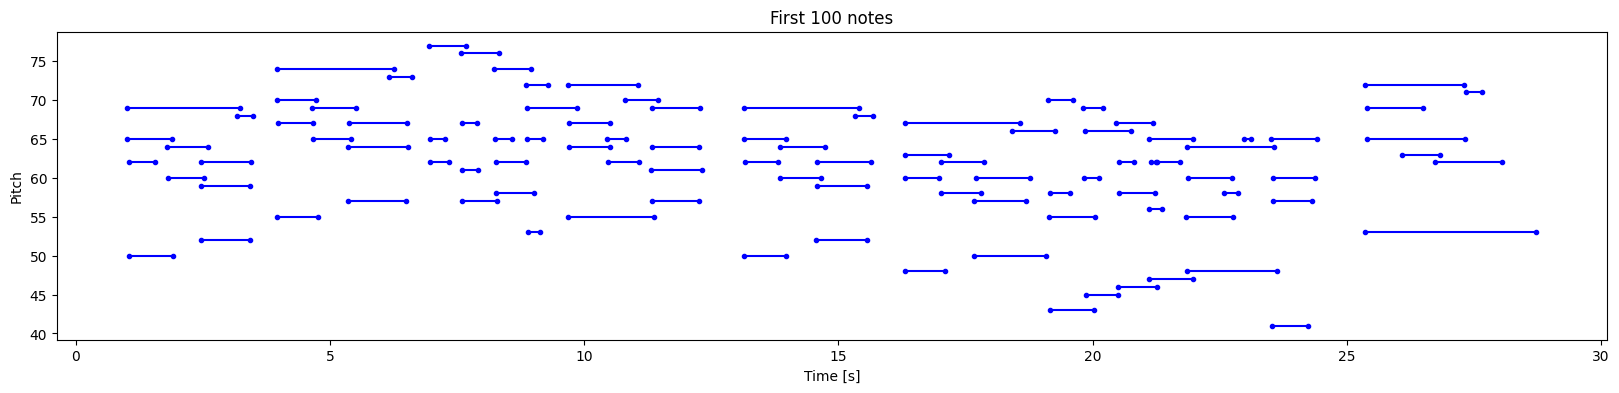

In [ ]:
plot_piano_roll(raw_notes, count=100)

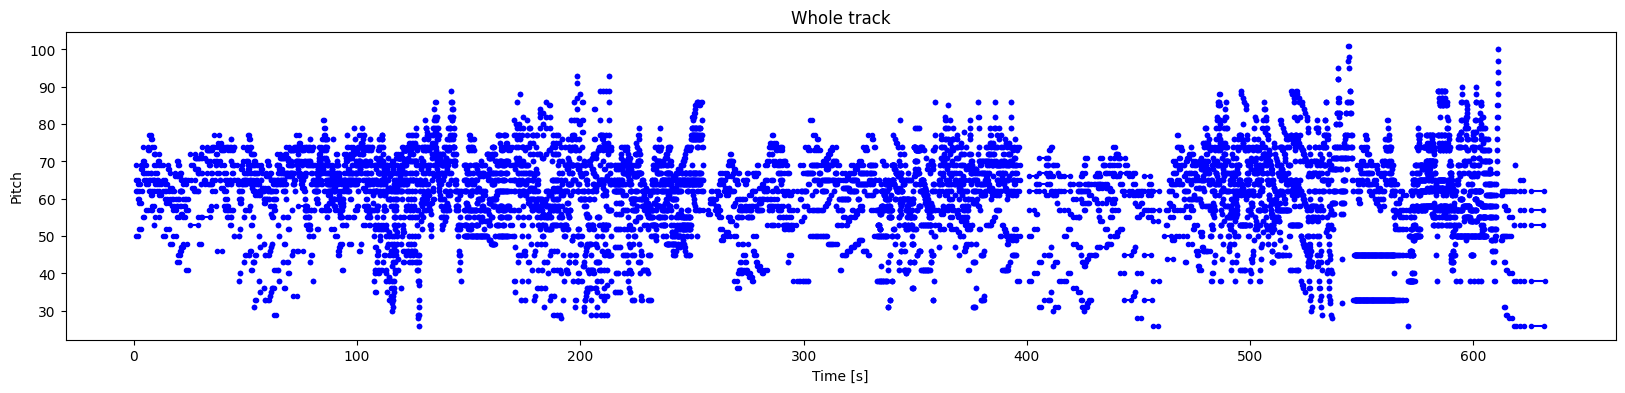

In [ ]:
plot_piano_roll(raw_notes)

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# Load the MAESTRO Version 2 dataset from CSV
maestro_v2_csv_path = "/content/sample_data/maestro-v2.0.0.csv"  # Provide the path to your MAESTRO Version 2 CSV file
maestro_v2_data = pd.read_csv(maestro_v2_csv_path)

# Preprocess the data
# Convert MIDI notes to numerical representation
notes = maestro_v2_data['midi_filename']  # Replace 'midi_notes_column' with the actual column name containing MIDI notes
pitchnames = sorted(set(notes))
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

# Create sequences of notes for input and corresponding target notes
sequence_length = 100  # Adjust according to your preference
network_input = []
network_output = []

for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])

# Normalize the input sequences
n_patterns = len(network_input)
n_vocab = len(set(notes))
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
network_input = network_input / float(n_vocab)

# Convert output to one-hot encoding
network_output = tf.keras.utils.to_categorical(network_output)

# Define the model architecture
model = Sequential([
    LSTM(256, input_shape=(network_input.shape[1], network_input.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(512, return_sequences=True),
    Dropout(0.3),
    LSTM(256),
    Dense(n_vocab, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Train the model
model.fit(network_input, network_output, epochs=10, batch_size=64)

# Function to generate music
def generate_music(model, seed_notes, num_notes_to_generate):
    generated_notes = []
    seed = seed_notes
    for i in range(num_notes_to_generate):
        predicted_note_probs = model.predict(np.array([seed]))
        predicted_note_index = np.argmax(predicted_note_probs)
        generated_notes.append(predicted_note_index)
        seed = np.append(seed, [[predicted_note_index]], axis=0)
    return generated_notes

# Example of providing an initial sequence to start music generation
# You can choose any random sequence from your dataset as the initial sequence
initial_sequence_index = np.random.randint(0, len(network_input) - 1)
initial_sequence = network_input[initial_sequence_index]

# Or you can create a random initial sequence
# For example, if your vocabulary size is n_vocab:
# initial_sequence = np.random.randint(0, n_vocab, size=(sequence_length, 1)) / float(n_vocab)

# Then you can use this initial sequence to generate music
num_notes_to_generate = 100  # adjust as needed
generated_music = generate_music(model, initial_sequence, num_notes_to_generate)


Epoch 1/10
19/19 [==============================] - 85s 4s/step - loss: 7.1430
Epoch 2/10
19/19 [==============================] - 76s 4s/step - loss: 7.1625
Epoch 3/10
19/19 [==============================] - 76s 4s/step - loss: 7.1727
Epoch 4/10
19/19 [==============================] - 77s 4s/step - loss: 7.1573
Epoch 5/10
19/19 [==============================] - 75s 4s/step - loss: 7.1615
Epoch 6/10
19/19 [==============================] - 75s 4s/step - loss: 7.1503
Epoch 7/10
19/19 [==============================] - 76s 4s/step - loss: 7.1248
Epoch 8/10
19/19 [==============================] - 76s 4s/step - loss: 7.1534
Epoch 9/10
19/19 [==============================] - 76s 4s/step - loss: 7.0771
Epoch 10/10
1/1 [==============================] - 0s 204ms/step
